# Efficient Grammar Fuzzing

In the [chapter on grammars](Grammars.ipynb), we have seen how to use _grammars_ for very effective and efficient testing.  In this chapter, we refine the previous string-based algorithm into a tree-based algorithm, which is much faster and allows for much more control over the production of fuzz inputs.

**Prerequisites**

* You should know how grammar-based fuzzing works, e.g. from the [chapter on grammars](Grammars.ipynb).

## A More Efficient Algorithm

While simple and straight-forward, our grammar production algorithm from the previous chapter suffers from two problems:

1. *It is inefficient*.  With each iteration, this fuzzer would go search the string produced so far for symbols to expand.  This becomes inefficient as the production string grows.

2. *It is hard to control.*  Even while limiting the number of symbols, it is still possible to obtain very long strings.

Both problems can be easily illustrated by plotting the time required for strings of different lengths.

In [95]:
import fuzzingbook_utils

In [96]:
from Grammars import simple_grammar_fuzzer
from Grammars import START_SYMBOL, EXPR_GRAMMAR, URL_GRAMMAR, CGI_GRAMMAR
from Grammars import RE_NONTERMINAL, nonterminals, is_nonterminal

In [97]:
from Timer import Timer

In [98]:
trials = 100
xs = []
ys = []
for i in range(trials):
    with Timer() as t:
        s = simple_grammar_fuzzer(EXPR_GRAMMAR, max_nonterminals=15)
    xs.append(len(s))
    ys.append(t.elapsed_time())
    print(i, end=" ")
    
average_time = sum(ys) / trials
print()
print("Average time:", average_time)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Average time: 0.19336059374000342


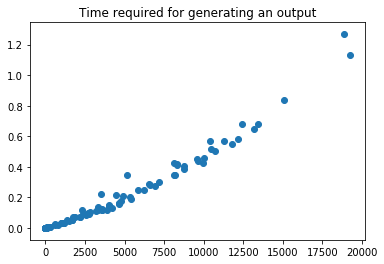

In [99]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.title('Time required for generating an output');

We see that (1) the effort increases quadratically over time, and (2) we can easily produce outputs that are tens of thousands of characters long.

## Derivation Trees

To both obtain a more efficient algorithm _and_ exercise better control over expansions, we will use a special representation for the strings that our grammar produces.  The general idea is to use a _tree_ structure that will be subsequently expanded – a so-called _derivation tree_.

The expansion process with derivation trees is illustrated in the following steps.  We use `dot` as a drawing program; you don't need to look at the code, just at its results.  We start with a single node as root of the tree.

In [100]:
from graphviz import Digraph

In [101]:
dot = Digraph("root")
dot.attr('node', shape='plain')
dot.node(r"\<start\>")
dot

We then traverse the tree, searching for a symbol to expand, and add a new edge from the symbol to its expansion.

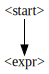

In [102]:
dot.edge(r"\<start\>", r"\<expr\>")
dot

To construct the actually produced string from the derivation tree, we traverse the tree in order and collect the symbols at the leaves of the tree.  In the case above, we obtain the string `<expr>`.

To further expand the tree, we choose a symbol to expand, and add a new edge from the symbol to its expansion.  This would get us the string `<expr> + <term>`.

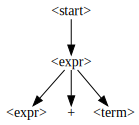

In [103]:
dot.edge(r"\<expr\>", r"\<expr\> ")
dot.edge(r"\<expr\>", r"+")
dot.edge(r"\<expr\>", r"\<term\>")
dot

We repeat the process until there are no symbols left to expand:

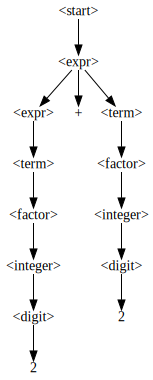

In [104]:
dot.edge(r"\<expr\> ", r"\<term\> ")
dot.edge(r"\<term\> ", r"\<factor\> ")
dot.edge(r"\<factor\> ", r"\<integer\> ")
dot.edge(r"\<integer\> ", r"\<digit\> ")
dot.edge(r"\<digit\> ", r"2 ")

dot.edge(r"\<term\>", r"\<factor\>")
dot.edge(r"\<factor\>", r"\<integer\>")
dot.edge(r"\<integer\>", r"\<digit\>")
dot.edge(r"\<digit\>", r"2")
dot

We now have a representation for the string `2 + 2`.  In contrast to the string alone, though, the derivation tree records the entire structure (and production history) of the produced string.  It also allows for simple comparison and manipulation – say, replacing one subtree (substructure) against another.

## Representing Derivation Trees

To represent a derivation tree in Python, we use the following format.  A node is a pair

```python
(SYMBOL_NAME, CHILDREN)
```

where `SYMBOL_NAME` is a string representing the node (i.e. `<start>` or `+`) and `CHILDREN` is a list of children nodes.

`CHILDREN` can take some special values:

1. `None` as a placeholder for future expansion.  This means that the node is a _nonterminal symbol_ that should be expanded further.
2. `[]` (i.e., the empty list) to indicate _no_ children.  This means that the node is a _terminal symbol_ that can no longer be expanded.

Let us take a very simple derivation tree, representing the intermediate step `<expr> + <term>`, above.

In [105]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<term>", None)]
         )])

Let's visualize this tree!  Again, we use the `dot` drawing program, but now do this algorithmically, traversing the above structure; as with the above visualizations, only the result counts.

In [106]:
from IPython.display import display

In [107]:
import re

In [108]:
def dot_escape(s):
    """Return s in a form suitable for dot"""
    # s = s.replace("\\", "\\\\")
    s = re.sub(r"([^a-zA-Z0-9 ])", r"\\\1", s)
    return s

In [109]:
assert dot_escape("hello") == "hello"
assert dot_escape("<hello>, world") == "\\<hello\\>\\, world"
assert dot_escape("\\n") == "\\\\n"

In [110]:
def display_tree(derivation_tree):
    """Visualize a derivation tree as SVG using the graphviz/dot package."""
    
    counter = 0
    def traverse_tree(dot, tree, id=0):
        (symbol, children) = tree
        dot.node(repr(id), dot_escape(symbol))
        
        if children is not None:
            for child in children:
                nonlocal counter  # Assign each node a unique identifier
                counter += 1
                child_id = counter
                dot.edge(repr(id), repr(child_id))
                traverse_tree(dot, child, child_id)

    dot = Digraph(comment="Derivation Tree")
    dot.attr('node', shape='plain')
    traverse_tree(dot, derivation_tree)
    display(dot)

This is what our tree visualizes into:

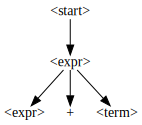

In [111]:
display_tree(derivation_tree)

To turn the tree into a string, the following function comes in handy:

In [112]:
def all_terminals(tree):
    (symbol, children) = tree
    if children is None:
        # This is a nonterminal symbol not expanded yet
        return symbol

    if len(children) == 0:
        # This is a terminal symbol
        return symbol

    # This is an expanded symbol:
    # Concatenate all terminal symbols from all children
    return ''.join([all_terminals(c) for c in children])

In [113]:
all_terminals(derivation_tree)

'<expr> + <term>'

## Expanding a Node

Let us now develop an algorithm that takes a tree with unexpanded symbols (say, `derivation_tree`, above), and expands all these symbols onbe after the other.  First, let us define a helper function that constructs a tree with just the start symbol:

In [114]:
def init_tree(start_symbol=START_SYMBOL):
    return (start_symbol, None)

In [115]:
display_tree(init_tree())

Next, we will need a helper function that takes an expansion string and converts it into a list of derivation trees:

In [116]:
def expansion_to_children(expansion):
    # print("Converting " + repr(expansion))
    # strings contains all substrings -- both terminals and non-terminals such
    # that ''.join(strings) == expansion

    # See nonterminals(), above
    if isinstance(expansion, tuple):
        expansion = expansion[0]

    if expansion == "":  # Special case: empty expansion
        return [("", [])]

    strings  = re.split(RE_NONTERMINAL, expansion)
    return [(s, None) if is_nonterminal(s) else (s, []) for s in strings if len(s) > 0]

In [117]:
expansion_to_children("<term> + <expr>")

[('<term>', None), (' + ', []), ('<expr>', None)]

The case of an empty expansion needs special treatment:

In [118]:
expansion_to_children("")

[('', [])]

With this, we can now take some unexpanded node in the tree, choose a random expansion, and return the new tree.

In [121]:
import random

In [122]:
def expand_node_randomly(node, grammar):
    (symbol, children) = node
    assert children is None
    
    # print("Expanding", all_terminals(node), "randomly")

    # Fetch the possible expansions from grammar...
    expansions = grammar[symbol]
    possible_children = [expansion_to_children(expansion) for expansion in expansions]

    # ... and select a random expansion
    children = random.choice(possible_children)

    # Return with new children
    return (symbol, children)

Before:


After:


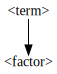

In [123]:
print("Before:")
tree = ("<term>", None)
display_tree(tree)

print("After:")
tree = expand_node_randomly(tree, EXPR_GRAMMAR)
display_tree(tree)

## Expanding a Tree

Let us now apply the above node expansion to some node in the tree.  To this end, we first need to search the tree for unexpanded nodes.  `possible_expansions()` counts how many unexpanded symbols there are in a tree:

In [124]:
def possible_expansions(tree):
    (symbol, children) = tree
    if children is None:
        return 1

    number_of_expansions = sum(possible_expansions(c) for c in children)
    return number_of_expansions

In [125]:
print(possible_expansions(derivation_tree))

2


`any_possible_expansions()` returns True if the tree has any unexpanded nodes.

In [126]:
def any_possible_expansions(tree):
    (symbol, children) = tree
    if children is None: return True

    return any(any_possible_expansions(c) for c in children)

In [127]:
print(any_possible_expansions(derivation_tree))

True


Here comes `expand_tree_once()`, the core method of our tree expansion algorithm.  It first checks whether it is currently being applied on a nonterminal symbol without expansion; if so, it invokes `expand_node_randomly()` on it as above.  (With the `expand_node` parameter, we can actually select the function to use for expansion.)

If the node is already expanded (i.e. has children), it checks the subset of children which still have unexpanded symbols; randomly selects one of them, and applies itself recursively on that child.

The `expand_tree_once()` function replaces the child _in place_, meaning that it actually mutates the tree being passed as an argument rather than returning a new tree.  This in-place mutation is what makes this function particularly efficient.

In [128]:
def expand_tree_once_randomly(tree, grammar, expand_node=expand_node_randomly):
    (symbol, children) = tree
    if children is None:
        # Expand this node
        return expand_node(tree, grammar)

    # print("Expanding tree " + repr(tree))

    # Find all children with possible expansions
    expandable_children = [i for (i, c) in enumerate(children) if any_possible_expansions(c)]

    # Select a random child
    # TODO: Various heuristics for choosing a child here,
    # e.g. grammar or code coverage
    child_to_be_expanded = random.choice(expandable_children)

    # Expand in place
    children[child_to_be_expanded] = expand_tree_once_randomly(children[child_to_be_expanded], 
                                                               grammar, expand_node=expand_node)

    return tree

Let's put it to use, expanding our derivation tree from above twice.

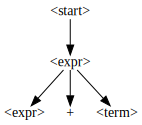

In [129]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<term>", None)]
         )])
display_tree(derivation_tree)

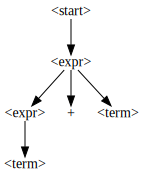

In [130]:
derivation_tree = expand_tree_once_randomly(derivation_tree, EXPR_GRAMMAR)
display_tree(derivation_tree)

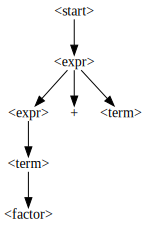

In [131]:
derivation_tree = expand_tree_once_randomly(derivation_tree, EXPR_GRAMMAR)
display_tree(derivation_tree)

We see that which each step, one more symbol is expanded.  Now all it takes is to apply this again and again, expanding the tree further and further.

## Closing the Expansion

With `expand_tree_once()`, we can keep on expanding the tree – but how do we actually stop?  The key idea here, introduced by Luke in \cite{Luke2000}, is that after inflating the derivation tree to some maximum size, we _only want to apply expansions that increase the size of the tree by a minimum_.  For `<factor>`, for instance, we would prefer an expansion into `<integer>`, as this will not introduce further recursion (and potential size inflation); for `<integer>`, likewise, an expansion into `<digit>` is preferred, as it will less increase tree size than `<digit><integer>`.

To identify the _cost_ of expanding a symbol, we introduce two functions that mutually rely on each other.  First, `symbol_min_cost()` returns the minimum cost of all expansions of a symbol, using `expansion_min_cost()` to compute the cost for each expansion.

In [132]:
def symbol_min_cost(symbol, grammar, seen=set()):
    expansions = grammar[symbol]
    return min(expansion_min_cost(e, grammar, seen | {symbol}) for e in expansions)

The function `expansion_min_cost()` returns the sum of all expansions in `expansions`.  If a nonterminal is encountered again during traversal, the cost of the expansion is $\infty$, as this indicates (potential infinite) recursion.

In [133]:
def expansion_min_cost(expansion, grammar, seen=set()):
    syms = nonterminals(expansion)
    if len(syms) == 0:
        return 1  # no symbol

    if any(s in seen for s in syms):
        return float('inf')

    # the value of a expansion is the sum of all expandable variables inside + 1
    return sum(symbol_min_cost(s, grammar, seen) for s in syms) + 1

Here's two examples: The minimum cost of expanding a digit is 1, since we have to choose between one of its expansions.

In [134]:
assert symbol_min_cost("<digit>", EXPR_GRAMMAR) == 1

The minimum number of expansions when expanding `<expr>`, though, is five, as this is the minimum number of expansions required.  (`<expr>` → `<term>` → `<factor>` → `<integer>` → `<digit>` → 1)

In [135]:
assert symbol_min_cost("<expr>", EXPR_GRAMMAR) == 5

Here's now a variant of `expand_node_randomly()` that takes the above cost into account.  It determines the minimum cost `min_cost` across all children and then uses the child with the minimum cost.  If multiple children all have the same minimum cost, it chooses randomly between these.

In [136]:
def expand_node_min_cost(node, grammar):
    (symbol, children) = node
    # print("Expanding " + repr(symbol))
    assert children is None

    # Fetch the possible expansions from grammar...
    expansions = grammar[symbol]

    possible_children_with_cost = [(expansion_to_children(expansion),
                                    expansion_min_cost(expansion, grammar, {symbol}))
                                  for expansion in expansions]

    min_cost = min(cost for (child, cost) in possible_children_with_cost)
    children_with_min_cost = [child for (child, child_cost) in possible_children_with_cost
                              if child_cost == min_cost]

    children = random.choice(children_with_min_cost)

    # Return with a new list
    return (symbol, children)

We can now apply this function to close the expansion of our derivation tree, using `expand_tree_once()` with the above `expand_node_min_cost()` as expansion function.

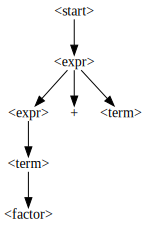

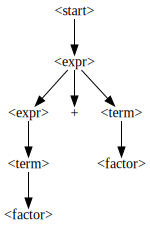

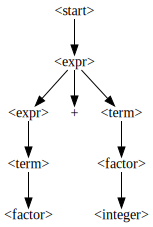

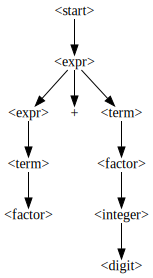

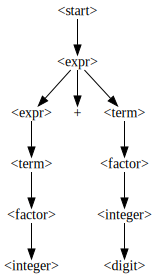

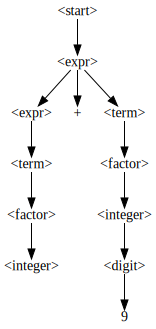

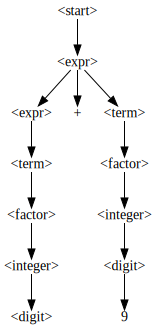

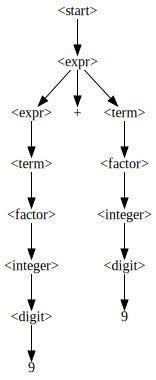

In [137]:
display_tree(derivation_tree)

while any_possible_expansions(derivation_tree):
    derivation_tree = expand_tree_once_randomly(derivation_tree, EXPR_GRAMMAR, 
                                                expand_node=expand_node_min_cost)
    display_tree(derivation_tree)

We see that in each step, `expand_node_min_cost()` chooses an expansion that does not increase the number of symbols, eventually closing all open expansions.

## All Together

We can now put both phases together in a single function `expand_tree()` that will expand a tree first with `expand_node_randomly()` until a limit of `max_nonterminals` possible expansions is reached, and then use `expand_node_min_cost()` to close the remaining expansions as quickly as possible.

In [138]:
def expand_tree(tree, grammar, max_nonterminals=10,
                expand_tree_once=expand_tree_once_randomly,
                expand_node=expand_node_randomly,
                disp=False, log=False):

    def _expand_tree_once(tree, grammar, expand_node, disp, log):
        tree = expand_tree_once(tree, grammar, expand_node=expand_node)
        if disp:
            display_tree(tree)
            print(possible_expansions(tree), "possible expansion(s) left")
        if log:
            print(tree)
        return tree

    if disp or log:
        print("Stage 1: Expanding until we reach", max_nonterminals, "unexpanded symbols")

    while 0 < possible_expansions(tree) < max_nonterminals:
        tree = _expand_tree_once(tree, grammar, expand_node, disp, log)

    if disp or log:
        print("Stage 2: Keep on expanding using shortest expansions only")

    while any_possible_expansions(tree):
        tree = _expand_tree_once(tree, grammar, expand_node_min_cost, disp, log)

    assert possible_expansions(tree) == 0

    return tree

Final tree


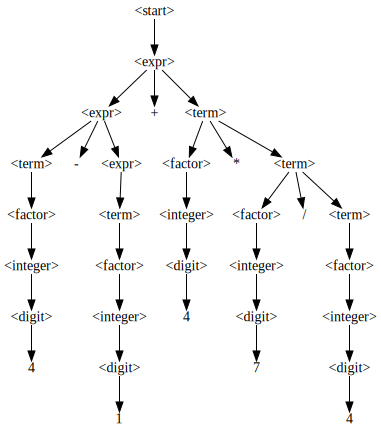

In [139]:
derivation_tree = ("<start>", 
        [("<expr>", 
          [("<expr>", None),
           (" + ", []),
           ("<term>", None)]
         )])

derivation_tree = expand_tree(derivation_tree, EXPR_GRAMMAR, max_nonterminals=5, disp=False)
print("Final tree")
display_tree(derivation_tree)

In [140]:
all_terminals(derivation_tree)

'4 - 1 + 4 * 7 / 4'

Based on this, we can now create a function `grammar_fuzzer()` that – like `simple_grammar_fuzzer()` – simply takes a grammar and produces a string from it, no longer exposing the complexity of derivation trees:

In [141]:
def grammar_fuzzer(grammar, max_nonterminals=10, start_symbol=START_SYMBOL, 
                   expand_tree_once=expand_tree_once_randomly,
                   expand_node=expand_node_randomly,
                   disp=False, log=False):

    # Create an initial derivation tree
    tree = init_tree(start_symbol)
    # print(tree)

    # Expand all nonterminals
    tree = expand_tree(tree, grammar, max_nonterminals, 
                       expand_tree_once=expand_tree_once,
                       expand_node=expand_node)
    if disp:
        print(repr(all_terminals(tree)))
        display_tree(tree)
    if log:
        print(tree)

    # Return the string
    return all_terminals(tree)

We can now apply this on all our defined grammars (and visualize the derivation tree along)

'41.67 / 1 * 1 - 72 * 7 - 68'


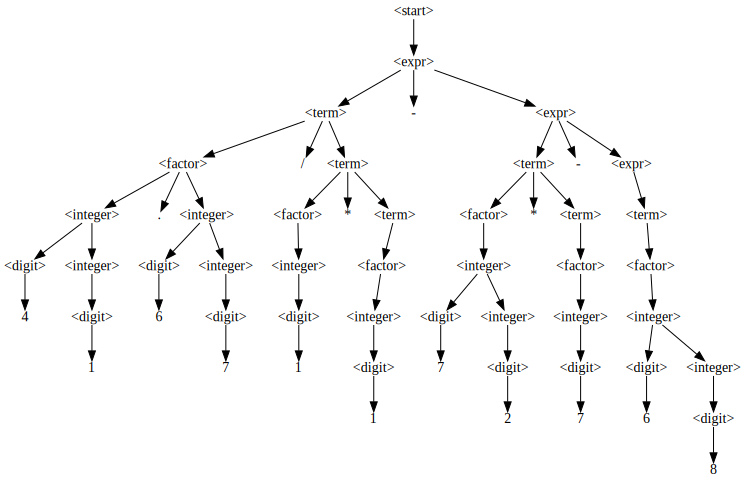

'41.67 / 1 * 1 - 72 * 7 - 68'

In [142]:
grammar_fuzzer(EXPR_GRAMMAR, disp=True)

'ftps://fuzzingbook.com:8080/abc'


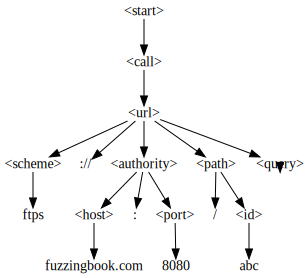

'ftps://fuzzingbook.com:8080/abc'

In [143]:
grammar_fuzzer(URL_GRAMMAR, disp=True)

'+'


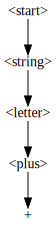

'+'

In [144]:
grammar_fuzzer(CGI_GRAMMAR, disp=True)

How do we stack up against `simple_grammar_fuzzer()`?

In [145]:
trials = 100
xs = []
ys = []
for i in range(trials):
    with Timer() as t:
        s = grammar_fuzzer(EXPR_GRAMMAR, max_nonterminals=20)
    xs.append(len(s))
    ys.append(t.elapsed_time())
    print(i, end=" ")

average_time = sum(ys) / trials
print()
print("Average time:", average_time)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Average time: 0.0319171800699678


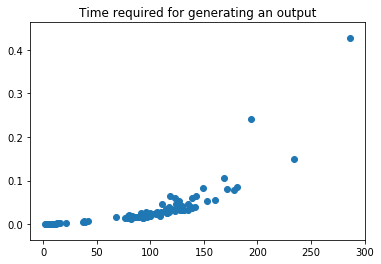

In [146]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.title('Time required for generating an output');

Our test generation is much faster, but also our inputs are much smaller.  \todo{(Actually, parts of the time gain may be due to the faster time.)}  We see that with derivation trees, we can get much better control over grammar production.

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducing.ipynb)


## Exercises

_Close the chapter with a few exercises such that people have things to do.  Use the Jupyter `Exercise2` nbextension to add solutions that can be interactively viewed or hidden.  (Alternatively, just copy the exercise and solution cells below with their metadata.)  We will set up things such that solutions do not appear in the PDF and HTML formats._

### Exercise 1

Speed up things by memoizing.

In [ ]:
# cache the function calls. We only cache a given call based on the
# indicated argument number per function.
def memoize(argnum):
    def fn_wrap(function):
        memo = {}
        def wrapper(*args):
            if args[argnum] in memo: return memo[args[argnum]]
            rv = function(*args)
            memo[args[argnum]] = rv
            return rv
        return wrapper
    return fn_wrap

_Solution for the exercise_

### Exercise 2

Speed up things by tracking which children still can be expanded.

_Solution for the exercise_

### Exercise 3

Introduce a parameter `min_symbols` that would keep on expanding with _maximum_ cost until `min_symbols` is reached.

In [ ]:
def expand_node_max_cost(node, grammar):
    (symbol, children) = node
    # print("Expanding " + repr(symbol))
    assert children is None

    # Fetch the possible expansions from grammar...
    expansions = grammar[symbol]

    possible_children_with_cost = [(expansion_to_children(expansion),
                                    expansion_min_cost(expansion, grammar, {symbol}))
                                  for expansion in expansions]

    min_cost = max(cost for (child, cost) in possible_children_with_cost)
    children_with_min_cost = [child for (child, child_cost) in possible_children_with_cost
                              if child_cost == min_cost]

    children = random.choice(children_with_min_cost)

    # Return with a new list
    return (symbol, children)

In [ ]:
def expand_tree_minmax(tree, grammar, min_nonterminals=10, max_nonterminals=10,
                expand_tree_once=expand_tree_once_randomly,
                expand_node=expand_node_randomly,
                disp=False, log=False):
    
    def _expand_tree_once(tree, grammar, expand_node, disp, log):
        tree = expand_tree_once(tree, grammar, expand_node)
        if disp:
            display_tree(tree)
            print(possible_expansions(tree), "possible expansion(s) left")
        if log:
            print(tree)
        return tree

    if disp or log:
        print("Stage 0: Expanding until we reach", max_nonterminals, "unexpanded nonterminals")

    while 0 < possible_expansions(tree) < min_nonterminals:
        tree = _expand_tree_once(tree, grammar, expand_node_max_cost, disp, log)
    
    if disp or log:
        print("Stage 1: Expanding until we reach", max_nonterminals, "unexpanded nonterminals")

    while 0 < possible_expansions(tree) < max_nonterminals:
        tree = _expand_tree_once(tree, grammar, expand_random_node, disp, log)

    if disp or log:
        print("Stage 2: Keep on expanding using shortest expansions only")

    while any_possible_expansions(tree):
        tree = _expand_tree_once(tree, grammar, expand_node_min_cost, disp, log)
        
    assert possible_expansions(tree) == 0

    return tree

In [ ]:
expanded_tree = expand_tree_minmax(init_tree(), EXPR_GRAMMAR, min_nonterminals=10, max_nonterminals=10)
print(repr(all_terminals(expanded_tree)))
display_tree(expanded_tree)

_Solution for the exercise_

### Exercise 4

Python 3.7 and later allow the use of _annotations_ to attach Python snippets to arbitrary syntactic elements.  You can make use of such annotations to produce even nicer grammars, using `|` to separate alternatives:

```python
from __future__ import annotations

class expression_grammar:
   start: "<expr>"
   expr: "<term> + <expr>" | "<term> - <expr>"
   term: "<factor> * <term>" | "<factor> / <term>" | "<factor>"
   factor: "+<factor>" | "-<factor>" | "(<expr>)" | "<integer>" | "<integer>.<integer>"
   integer: "<digit> <integer>" | "<digit>"
   digit: '0' | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
```

The annotation can be accessed using the `__annotations__` attribute:

```python
print(expression_grammar.__annotations__)
{'start': "'<expr>'", 'expr': "'<term> + <expr>' | '<term> - <expr>'", 
 'term': "'<factor> * <term>' | '<factor> / <term>' | '<factor>'", 
 ...}
```

Using Python 3.7 or later, write a converter that takes a grammar class using the above syntax and convert it to the "portable" format described in this chapter.

_Solution for the exercise_